In [1]:
'''This script loads pre-trained word embeddings (GloVe embeddings)
into a frozen Keras Embedding layer, and uses it to
train a text classification model on the 20 Newsgroup dataset
(classification of newsgroup messages into 20 different categories).
GloVe embedding data can be found at:
http://nlp.stanford.edu/data/glove.6B.zip
(source page: http://nlp.stanford.edu/projects/glove/)
'''

from __future__ import print_function

import os
import sys
import numpy as np
import json
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D,LSTM
from keras.layers import Conv1D, MaxPooling1D, Embedding,SimpleRNN
from keras.models import Model,Sequential
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras import regularizers
from pandas_ml import ConfusionMatrix
from sklearn.metrics import accuracy_score

C:\Users\wenqi\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
TEXT_DATA_DIR = os.path.join(BASE_DIR, '20_newsgroup')
MAX_SEQUENCE_LENGTH = 150
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2


In [3]:


# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'),encoding='utf-8') as f:
    
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))


Indexing word vectors.
Found 400000 word vectors.


In [4]:
file_list = os.listdir('data')
file_list
X=[]
Y=[]
for file in file_list:
    with open('data/'+file,'r') as f:
        d = json.load(f)
        X.extend(d['text'].values())
        Y.extend(d['sentiment'].values())

In [5]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3710 unique tokens.


In [6]:
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [7]:
tokenizer=Tokenizer()

tokenizer.fit_on_texts(Y)

Y = tokenizer.texts_to_matrix(Y)

Y = np.asarray([a[1:] for a in Y])

In [8]:
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (622, 150)
Shape of label tensor: (622, 3)


In [9]:
(x_train,x_test,y_train,y_test)=train_test_split(X,Y,random_state=42)

In [10]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [11]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [12]:
rglrzr = regularizers.l2(0.0015)

In [13]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(150,recurrent_regularizer=rglrzr))
model.add(Dense(3,activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

history=model.fit(x_train, y_train,
          batch_size=128,
          epochs=25,
          validation_data=(x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          371100    
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               150600    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 453       
Total params: 522,153
Trainable params: 151,053
Non-trainable params: 371,100
_________________________________________________________________
Train on 466 samples, validate on 156 samples
Epoch 1/25
466/466 [==============================] - 3s 7ms/step - loss: 1.2893 - acc: 0.4292 - val_loss: 1.1167 - val_acc: 0.4423
Epoch 2/25
466/466 [==============================] - 2s 4ms/step - loss: 1.1336 - acc: 0.5215 - val_loss: 1.0797 - val_acc: 0.4487
Epoch 3/25
466/466 [==============================] - 2s 4ms/step - loss: 1.0952 - a

In [14]:
y_pred = model.predict(x_test)
def maxpos(li):
    if li[0]>li[1] and li[0]>li[2] :
        return 'positive'
    if li[1]>li[2] and li[1]>li[0] :
        return 'neutral'
    return 'negative'
y_pre=[maxpos(y) for y in y_pred]
y_tes=[maxpos(y) for y in y_test]

In [15]:
confusion_matrix(y_true=y_tes,y_pred=y_pre)

array([[ 3,  2,  6],
       [ 3, 32, 24],
       [ 6, 15, 65]], dtype=int64)

Accuracy Score:  0.6410256410256411
Predicted  negative  neutral  positive  __all__
Actual                                         
negative          3        2         6       11
neutral           3       32        24       59
positive          6       15        65       86
__all__          12       49        95      156


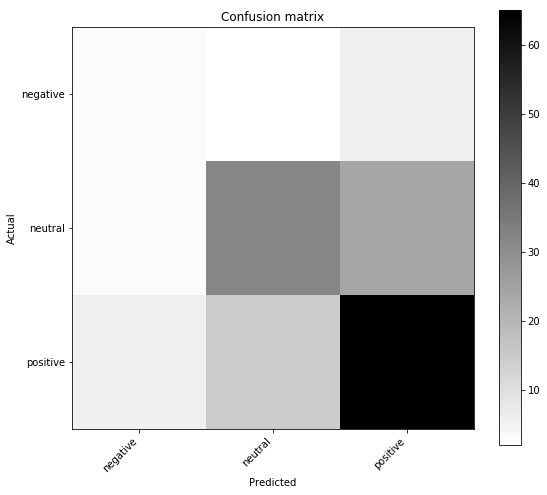

In [16]:
cnf_matrix = ConfusionMatrix(y_tes, y_pre)
acc_score = accuracy_score(y_tes, y_pre)


print('Accuracy Score: ', acc_score)

print(cnf_matrix)

cnf_matrix.plot()
plt.show()

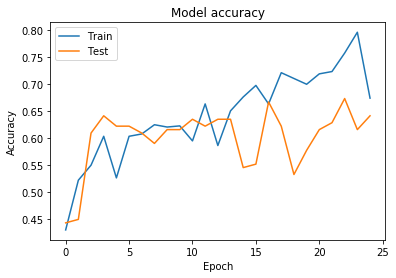

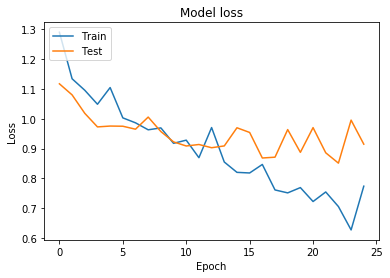

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()